## Ref

https://www.frontiersin.org/journals/computer-science/articles/10.3389/fcomp.2019.00009/full

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

マップ作製やルート作成で使う関数を作成する

In [2]:
def generate_graph(num_nodes: int, edge_p: float) -> nx.Graph:
    """
    ランダムな連結グラフを生成する
    """
    # https://qiita.com/igenki/items/9309d2fee5e0ff7d529e を見ると用いる関数によって、生成されるグラフの性質が変わるらしい
    # TODO: 最適な関数を選択する
    while True:
        g = nx.erdos_renyi_graph(num_nodes, edge_p)
        if nx.is_connected(g) is True:
            # 必ず連結なグラフを生成する
            break
    for u, v in g.edges():
        g.edges[u, v]["weight"] = random.randint(1, 10)
    return g

In [3]:
def generate_candidate_routes(shortest_path: list[int]) -> list[list[int]]:
    """
    最短路に沿って、先頭から順にノードを追加する形で候補経路を生成する。
    例えば、[8, 9, 7, 4, 5, 6] であれば
      [8], [8, 9], [8, 9, 7], … といったリストを作成する。
    """
    candidate_routes = []
    # 1ステップ目から全体まで
    for i in range(1, len(shortest_path) + 1):
        candidate_routes.append(shortest_path[:i])
    return candidate_routes

In [4]:
def generate_candidate(G: nx.Graph, start=None, goal=None) -> list[list[int]]:
    """
    グラフ G のノードからランダムに start, goal を選び、最短路を用いる経路候補を作成する
    """
    nodes = list(G.nodes())
    if start is None:
        start_node = random.choice(nodes)
    else:
        start_node = start
    if goal is None:
        goal_node = random.choice(nodes)
    else:
        goal_node = goal
    # start_node と goal_node が同じにならないようにする
    while start_node == goal_node:
        goal_node = random.choice(nodes)
    shortest_path = nx.shortest_path(G, start_node, goal_node)
    candidate_routes = generate_candidate_routes(shortest_path)

    return candidate_routes

In [5]:
def plot_graph(g: nx.Graph):
    """
    グラフを描画する
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    pos = nx.spring_layout(g)
    edge_labels = nx.get_edge_attributes(g, "weight")
    nx.draw(g, pos, with_labels=True, ax=ax)
    nx.draw_networkx_edge_labels(
        g,
        pos,
        edge_labels=edge_labels,
        ax=ax,
    )

    return fig, ax

最適化を行うグラフの生成

(<Figure size 800x600 with 1 Axes>, <Axes: >)

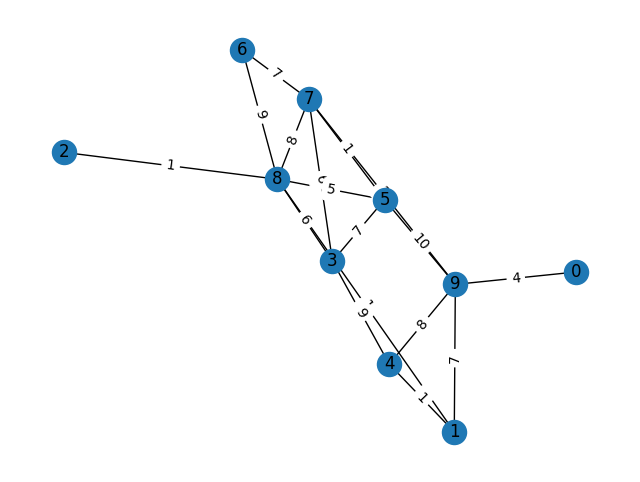

In [6]:
N_NODES = 10
PROBE_EDGE = 0.3
N_VEHICLES = 3
G = generate_graph(N_NODES, PROBE_EDGE)
plot_graph(G)

経路候補作成の動作確認

In [7]:
candidates = [generate_candidate(G) for _ in range(N_VEHICLES)]
for i, candidate in enumerate(candidates):
    print(f"Vehicle {i + 1}:")
    for j, route in enumerate(candidate):
        print(f"  Route {j + 1}: {route}")

Vehicle 1:
  Route 1: [4]
  Route 2: [4, 1]
  Route 3: [4, 1, 8]
  Route 4: [4, 1, 8, 2]
Vehicle 2:
  Route 1: [8]
  Route 2: [8, 2]
Vehicle 3:
  Route 1: [2]
  Route 2: [2, 8]


`jijmodeling`を用いた定式化

In [8]:
def compute_route_cost(g: nx.Graph, route: list[int]) -> int:
    """
    与えられた経路のコストを計算する
    """
    cost = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        cost += g.edges[u, v]["weight"]
    return cost

In [9]:
route_costs = [
    [compute_route_cost(G, route) for route in candidate] for candidate in candidates
]
for i, candidate in enumerate(candidates):
    print(f"Vehicle {i + 1}:")
    for j, route in enumerate(candidate):
        print(f"  Route {j + 1}: {route_costs[i][j]}")

Vehicle 1:
  Route 1: 0
  Route 2: 1
  Route 3: 2
  Route 4: 3
Vehicle 2:
  Route 1: 0
  Route 2: 1
Vehicle 3:
  Route 1: 0
  Route 2: 1


In [10]:
import jijmodeling as jm
import numpy as np

C = [len(candidate) for candidate in candidates]
MAX_CANDIDATE = max(C)

# TODO: 各ルートに1つずつの変数が望ましいが、やり方が分からないのでとりあえずこのようにする
q = jm.BinaryVar("q", shape=(N_VEHICLES, MAX_CANDIDATE))
u = jm.Element("i", belong_to=(0, N_VEHICLES))
v = jm.Element("v", belong_to=(0, MAX_CANDIDATE))
W = jm.Placeholder("W", ndim=2)
n_candidate = jm.Placeholder("n_candidate", ndim=1)

目的関数: 移動距離の最大化

In [11]:
problem = jm.Problem("guide", sense=jm.ProblemSense.MINIMIZE)

moving_cost = -jm.sum([u, v], q[u, v] * W[u, v])
problem += moving_cost

制約条件

- 1つの経路しか選択しない

In [12]:
problem += jm.Constraint("one route", jm.sum([v], q[u, v]) == 1, forall=u)

In [13]:
problem

移動量`W`に値を設定する。存在しない候補は移動しないものとしておく

In [14]:
Wvec = np.zeros((N_VEHICLES, MAX_CANDIDATE))
for u in range(N_VEHICLES):
    for v in range(MAX_CANDIDATE):
        if v < C[u]:
            # 候補経路がある場合
            Wvec[u, v] = route_costs[u][v]
        else:
            # 候補経路がない場合
            Wvec[u, v] = 0

instance_data = {"W": Wvec, "n_candidate": C}

In [15]:
import jijmodeling_transpiler as jmt
from openjij import SASampler

sampler = SASampler()

In [16]:
compiled_model = jmt.core.compile_model(problem, instance_data, {})
pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_model=compiled_model)
qubo, const = pubo_builder.get_qubo_dict(multipliers={"one route": 100.0})

In [17]:
num_reads = 1000
sampleset = sampler.sample_qubo(qubo, num_reads=num_reads)

In [18]:
ans = sampleset.lowest().record[0][0].reshape((N_VEHICLES, MAX_CANDIDATE))

In [19]:
ans

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=int8)

可視化

=== 各車両の選択結果 ===
Vehicle 1: Candidate 4 -> Route: [4, 1, 8, 2], Cost: 3
Vehicle 2: Candidate 2 -> Route: [8, 2], Cost: 1
Vehicle 3: Candidate 2 -> Route: [2, 8], Cost: 1


/workspaces/qa4u3/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/qa4u3/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36554 (\N{CJK UNIFIED IDEOGRAPH-8ECA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/qa4u3/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20001 (\N{CJK UNIFIED IDEOGRAPH-4E21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/qa4u3/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/qa4u3/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36984 (\N{CJK UNIFIED IDEOGR

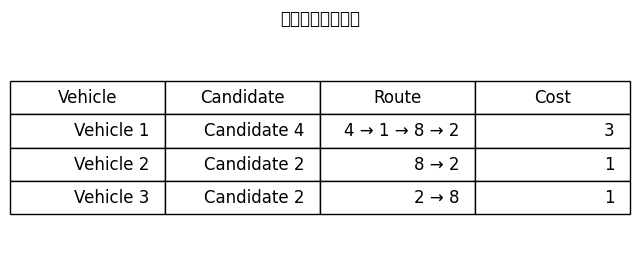

In [20]:
selected_indices = ans.argmax(axis=1)

# 選択結果をテキスト出力
print("=== 各車両の選択結果 ===")
for i in range(N_VEHICLES):
    candidate_index = selected_indices[i]
    chosen_route = candidates[i][candidate_index]
    cost_val = route_costs[i][candidate_index]
    print(
        f"Vehicle {i + 1}: Candidate {candidate_index + 1} -> Route: {chosen_route}, Cost: {cost_val}"
    )

# ----- テーブル表示による可視化 -----
# 各車両ごとに選択された候補の情報をまとめる
table_data = []
for i in range(N_VEHICLES):
    candidate_index = selected_indices[i]
    route_str = " → ".join(map(str, candidates[i][candidate_index]))
    cost_val = route_costs[i][candidate_index]
    table_data.append(
        [f"Vehicle {i + 1}", f"Candidate {candidate_index + 1}", route_str, cost_val]
    )

# グラフを用いてテーブルを描画
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis("tight")
ax.axis("off")
table = ax.table(
    cellText=table_data,
    colLabels=["Vehicle", "Candidate", "Route", "Cost"],
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
plt.title("各車両の選択経路")
plt.show()